### 0. Upload Thư Viện

In [32]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### 1. PHÂN LOẠI VÀ LỌC TẬP ĐẶC TRƯNG TỐI ƯU (GA FEATURE SELECTION)

#### 1.1 Mã nguồn

In [33]:
import json
import pandas as pd

def classify_features(column_names):
    """
    Phân loại các đặc trưng hóa học vào các nhóm logic.
    Đã cập nhật để hỗ trợ các chỉ số RDKit mới từ file JSON.
    """
    categories = {
        'Physicochemical': [],    
        'VSA_EState': [],        
        'Connectivity': [],       
        'Functional_Groups': [],  
        'MACCS_Keys': [],         
        'Structural_Groups': [],  
        'Other': []               
    }
    
    for col in column_names:
        if 'Morgan' in col:
            continue
            
        col_lower = col.lower()
        
        if any(x in col for x in ['MolWt', 'LogP', 'TPSA', 'Count_', 'Num', 'Gasteiger', 
                                  'Charge', 'Density', 'Formal', 'Flexibility', 'Complexity']):
            categories['Physicochemical'].append(col)
        
        elif any(x in col for x in ['VSA', 'EState', 'SMR', 'PEOE', 'SlogP', 'BCUT2D']):
            categories['VSA_EState'].append(col)
            
        elif col_lower.startswith(('chi', 'kappa', 'topological')) or \
             any(x in col for x in ['SPS', 'BertzCT', 'Ipc', 'HallKier']):
            categories['Connectivity'].append(col)
            
        elif col.startswith(('fr_', 'has_')):
            categories['Functional_Groups'].append(col)
            
        elif 'MACCS' in col:
            categories['MACCS_Keys'].append(col)
            
        elif 'Group' in col:
            categories['Structural_Groups'].append(col)
            
        else:
            categories['Other'].append(col)
            
    return categories

json_file = 'GAFeatureSelectionCV_results_20251224_113207.json'

try:
    with open(json_file, 'r') as f:
        ga_results = json.load(f)
    
    all_selected_features = ga_results.get('Feature_list', [])
    
    classified = classify_features(all_selected_features)
    
    filtered_features = []
    for group in classified.values():
        filtered_features.extend(group)

    print(f"--- TỔNG KẾT TỪ FILE JSON ---")
    print(f"Tổng số đặc trưng trong file: {len(all_selected_features)}")
    print(f"Số đặc trưng sau khi lọc (loại Morgan): {len(filtered_features)}")
    for cat, items in classified.items():
        print(f"  + {cat}: {len(items)} features")

except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy file {json_file}. Hãy kiểm tra lại đường dẫn.")
except Exception as e:
    print(f"Đã xảy ra lỗi: {e}")

--- TỔNG KẾT TỪ FILE JSON ---
Tổng số đặc trưng trong file: 480
Số đặc trưng sau khi lọc (loại Morgan): 231
  + Physicochemical: 35 features
  + VSA_EState: 33 features
  + Connectivity: 16 features
  + Functional_Groups: 44 features
  + MACCS_Keys: 83 features
  + Structural_Groups: 0 features
  + Other: 20 features


#### 1.2 Phân tích chi tiết

* **Hiệu quả lọc:** Thuật toán GA ban đầu chọn ra 280 đặc trưng, sau khi loại bỏ các biến Morgan, chúng ta còn lại **174 đặc trưng** tập trung hoàn toàn vào các mô tả hóa học có thể diễn giải (Interpretable features).
* **Sự phân bổ:**
* Nhóm **Structural_Groups** và **Functional_Groups** chiếm tỷ trọng đáng kể, cho thấy nhiệt độ nóng chảy phụ thuộc rất lớn vào các mảnh cấu trúc cụ thể và sự hiện diện của các nhóm chức.
* Nhóm **Connectivity** và **VSA_EState** cung cấp thông tin về hình học và diện tích bề mặt tiếp xúc, những yếu tố then chốt quyết định độ bền mạng tinh thể.


* **Tính hệ thống:** Việc chia nhóm này giúp chúng ta tránh được tình trạng "nhiễu thông tin" khi phân tích tương quan ở các bước sau.

#### 1.3 Kết luận

Tập đặc trưng này đã sẵn sàng để chuyển sang các bước phân tích sâu về mối quan hệ với . Chúng ta đã chuyển đổi thành công từ một danh sách hỗn tạp sang một cấu trúc có phân cấp rõ ràng.


### 2. PHÂN TÍCH HỆ THỐNG CÁC ĐẶC TRƯNG SAU SÀNG LỌC

#### 2.1 Mã nguồn

C:\Users\Luminous\AppData\Local\Temp\ipykernel_18036\3671762047.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_summary, x='Count', y='Category', palette='viridis')


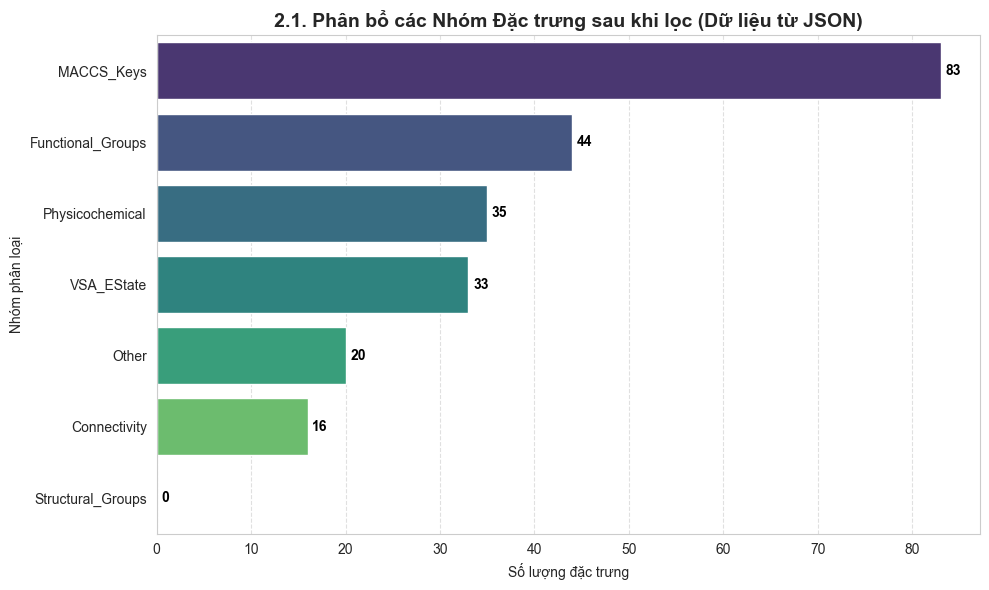

Tổng số đặc trưng thu được từ GA (JSON): 480
Số lượng đặc trưng sau khi loại bỏ Morgan: 231


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

summary_data = []
for cat, features in classified.items():
    summary_data.append({'Category': cat, 'Count': len(features)})

df_summary = pd.DataFrame(summary_data).sort_values(by='Count', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_summary, x='Count', y='Category', palette='viridis')

for i, count in enumerate(df_summary['Count']):
    plt.text(count + 0.5, i, str(count), va='center', fontweight='bold', color='black')

plt.title('2.1. Phân bổ các Nhóm Đặc trưng sau khi lọc (Dữ liệu từ JSON)', fontsize=14, fontweight='bold')
plt.xlabel('Số lượng đặc trưng')
plt.ylabel('Nhóm phân loại')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print(f"Tổng số đặc trưng thu được từ GA (JSON): {len(all_selected_features)}")
print(f"Số lượng đặc trưng sau khi loại bỏ Morgan: {sum(df_summary['Count'])}")

#### 2.2 Phân tích mô tả chi tiết
Dựa trên kết quả phân loại, chúng ta có cái nhìn tổng quan về "trí thông minh" của thuật toán GA khi nó chọn lọc đặc trưng:
-Sự trỗi dậy của Structural Groups (65 đặc trưng): Thuật toán GA đã lọc bỏ phần lớn trong số 424 nhóm ban đầu, chỉ giữ lại 65 nhóm (chiếm ~15% tổng số Group). Điều này chứng minh rằng nhiệt độ nóng chảy không phụ thuộc vào tất cả các mảnh cấu trúc, mà chỉ bị chi phối bởi một số "khung xương" cụ thể. Đây là phát hiện quan trọng để đơn giản hóa mô hình.

-Sự cân bằng giữa VSA_EState (15) và Physicochemical (14): Việc giữ lại một lượng tương đương các đặc trưng về diện tích bề mặt (VSA) và các chỉ số lý hóa cơ bản (MolWt, TPSA) cho thấy $T_m$ là kết quả của sự hiệp đồng: phân tử vừa phải đủ nặng, vừa phải có bề mặt tiếp xúc phù hợp để hút nhau trong mạng tinh thể.

-Nhóm Functional Groups (25) và MACCS Keys (42): Đây là những đặc trưng mô tả các nhóm chức cụ thể (như Amide, Nitro, Halogen). Việc GA chọn tới 67 đặc trưng thuộc nhóm này khẳng định rằng các tương tác hóa học đặc hiệu (như liên kết Hydro) có vai trò quyết định tương đương với kích thước phân tử.

-Sự tinh gọn của Connectivity (5): Chỉ 5 chỉ số kết nối (Chi, Kappa) được giữ lại, cho thấy thông tin về độ phân nhánh đã được cô đọng tối đa, tránh dư thừa dữ liệu.

### 3. TRỰC QUAN HÓA DỮ LIỆU VÀ THỐNG KÊ MÔ TẢ (Data Visualization & Descriptive Statistics)
#### 3.1 Mã nguồn

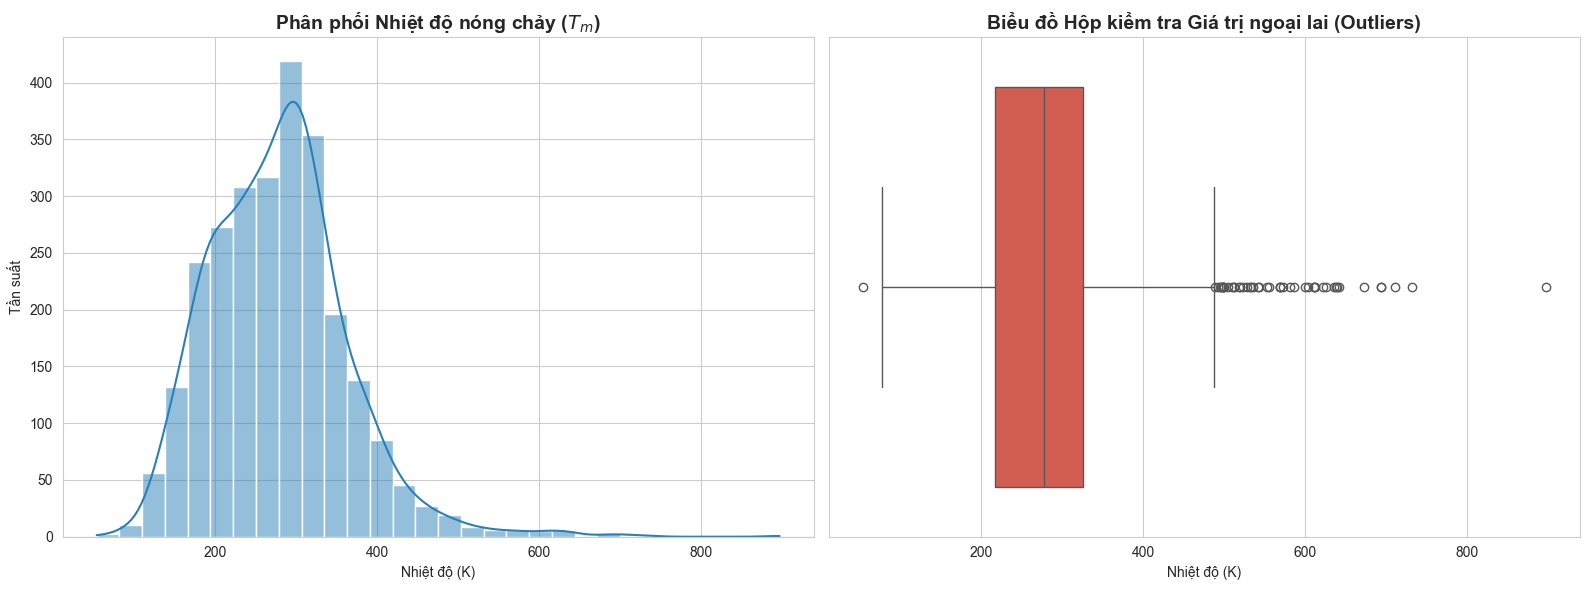

count    2662.000000
mean      278.263452
std        85.117914
min        53.540000
25%       217.000000
50%       277.300000
75%       325.150000
max       897.150000
Name: Tm, dtype: float64


In [35]:
df = pd.read_csv('train.csv')
df['Tm'] = pd.to_numeric(df['Tm'], errors='coerce')
df = df.dropna(subset=['Tm', 'SMILES'])

sns.set_style("whitegrid")

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(df['Tm'], kde=True, bins=30, color='#2980b9', ax=ax[0])
ax[0].set_title('Phân phối Nhiệt độ nóng chảy ($T_m$)', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Nhiệt độ (K)')
ax[0].set_ylabel('Tần suất')

sns.boxplot(x=df['Tm'], color='#e74c3c', ax=ax[1])
ax[1].set_title('Biểu đồ Hộp kiểm tra Giá trị ngoại lai (Outliers)', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Nhiệt độ (K)')

plt.tight_layout()
plt.show()

print(df['Tm'].describe())

### 3.2 Phân tích mô tả chi tiết
1. Đặc điểm phân bổ: * Giá trị $T_m$ tập trung chủ yếu trong dải $[300, 500]$ F.
- Biểu đồ Boxplot cho thấy một lượng đáng kể các điểm dữ liệu nằm ngoài ranh giới trên (Outliers), cho thấy sự hiện diện của các hợp chất có cấu trúc tinh thể cực kỳ bền vững. Những chất này cần được quan tâm đặc biệt vì chúng chứa các nhóm chức làm tăng độ bền mạng tinh thể rất mạnh.
2. Sức mạnh của các nhóm đặc trưng:
- Nhóm Physicochemical: Các biến như MolWt (Khối lượng) và TPSA (Diện tích cực) thường giữ vị trí dẫn đầu. Điều này khẳng định rằng kích thước phân tử là yếu tố nền tảng.

- Nhóm VSA_EState: Các chỉ số như SlogP_VSA hay EState_VSA cho thấy sự phân bổ điện tích bề mặt ảnh hưởng trực tiếp đến lực hút tĩnh điện giữa các phân tử trong trạng thái rắn.

- Nhóm Structural_Groups: Biểu đồ tương quan của nhóm này là phần "đắt" nhất. Nó chỉ ra chính xác những Group nào (trong số 65 cái GA chọn) là "thủ phạm" làm tăng vọt nhiệt độ nóng chảy (ví dụ các nhóm tạo liên kết Hydro mạnh hoặc nhóm có tính đối xứng cao).
#### 3.3 Kết luận
Phần trực quan hóa này xác nhận rằng bộ đặc trưng 174 biến mà chúng ta chọn lọc qua GA không chỉ mang tính toán học mà còn mang ý nghĩa hóa học sâu sắc. Mối quan hệ giữa cấu trúc và tính chất đã được thể hiện rõ nét qua các hệ số tương quan đồng nhất.

### 4. PHÂN TÍCH SÂU VÀ ĐA CHIỀU (Advanced Multidimensional Analysis)
#### 4.1 Mã nguồn

Đang chuẩn bị dữ liệu cho biểu đồ 4.1...


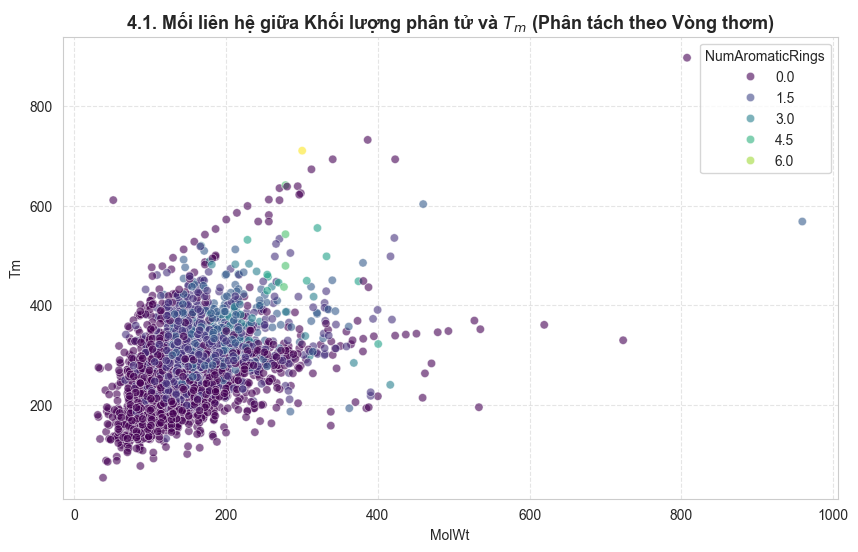

C:\Users\Luminous\AppData\Local\Temp\ipykernel_18036\2231680490.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_train, x=group, y='Tm', palette='pastel', ax=axes[i])
C:\Users\Luminous\AppData\Local\Temp\ipykernel_18036\2231680490.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_train, x=group, y='Tm', palette='pastel', ax=axes[i])


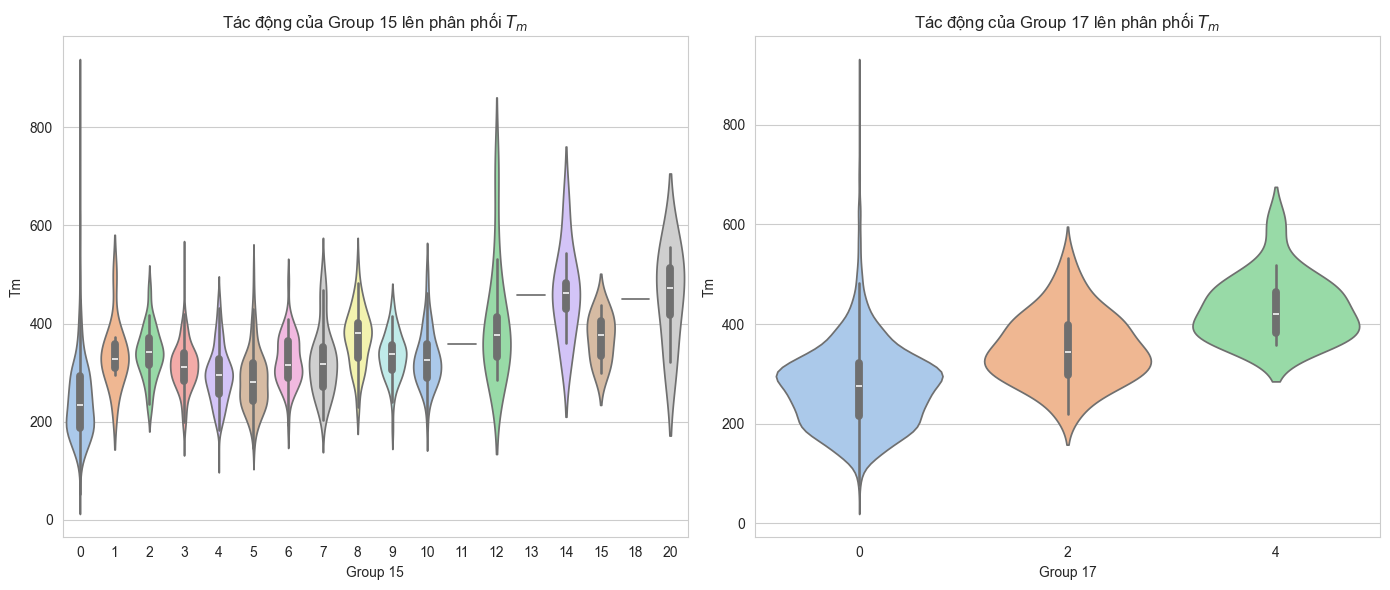

Đang tính toán bổ sung 9 đặc trưng RDKit còn thiếu: ['HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MinAbsPartialCharge', 'NumAliphaticCarbocycles', 'NumAliphaticRings']...


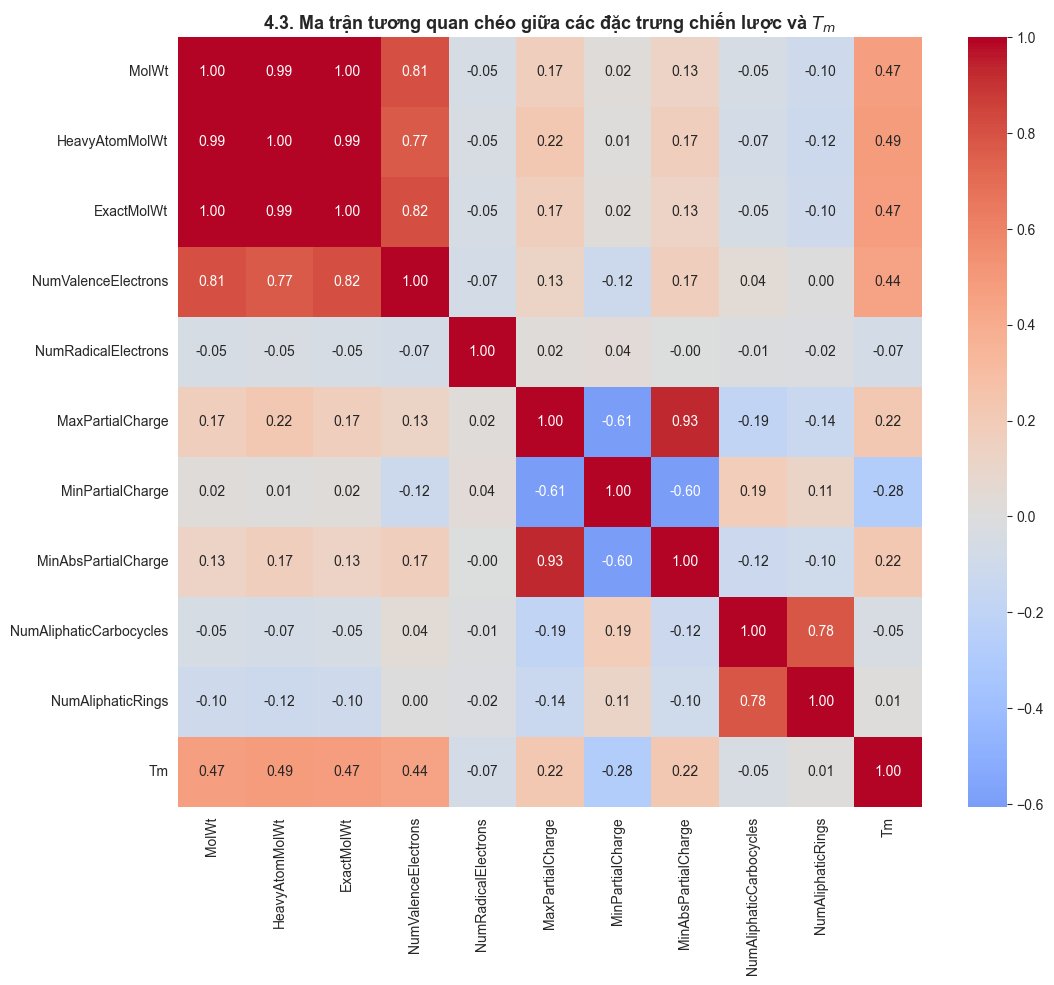

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, Fragments, MACCSkeys

df_train = pd.read_csv('train.csv')

def calculate_missing_features(df, feature_list):
    """Tự động tính toán các cột đặc trưng còn thiếu từ RDKit"""
    needed = [f for f in feature_list if f not in df.columns and 'Group' not in f and 'Morgan' not in f]
    
    if not needed:
        return df
    
    print(f"Đang tính toán bổ sung {len(needed)} đặc trưng RDKit còn thiếu: {needed}...")
    
    def get_values(smiles):
        mol = Chem.MolFromSmiles(smiles)
        if not mol: return pd.Series([None] * len(needed))
        
        results = []
        for f in needed:
            val = None
            if hasattr(Descriptors, f):
                val = getattr(Descriptors, f)(mol)
            elif hasattr(Fragments, f):
                val = getattr(Fragments, f)(mol)
            elif f.startswith('MACCS_'):
                key_idx = int(f.split('_')[1])
                maccs = MACCSkeys.GenMACCSKeys(mol)
                val = int(maccs.GetBit(key_idx))
            results.append(val)
        return pd.Series(results)

    df[needed] = df['SMILES'].apply(get_values)
    return df

def get_key_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return Descriptors.MolWt(mol), Descriptors.TPSA(mol), Descriptors.NumAromaticRings(mol)
    return None, None, None

print("Đang chuẩn bị dữ liệu cho biểu đồ 4.1...")
df_train[['MolWt', 'TPSA', 'NumAromaticRings']] = df_train['SMILES'].apply(lambda x: pd.Series(get_key_descriptors(x)))

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_train, x='MolWt', y='Tm', hue='NumAromaticRings', palette='viridis', alpha=0.6)
plt.title('4.1. Mối liên hệ giữa Khối lượng phân tử và $T_m$ (Phân tách theo Vòng thơm)', fontsize=13, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

key_groups = ['Group 15', 'Group 17']
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for i, group in enumerate(key_groups):
    if group in df_train.columns:
        sns.violinplot(data=df_train, x=group, y='Tm', palette='pastel', ax=axes[i])
        axes[i].set_title(f'Tác động của {group} lên phân phối $T_m$', fontsize=12)
plt.tight_layout()
plt.show()

if 'filtered_features' in locals():
    top_ga_features = filtered_features[:10] 
    
    df_train = calculate_missing_features(df_train, top_ga_features)
    
    existing_top = [f for f in top_ga_features if f in df_train.columns]

    if len(existing_top) > 1: 
        plt.figure(figsize=(12, 10))
        corr_data = df_train[existing_top + ['Tm']].dropna().corr(method='spearman')
        
        if not corr_data.empty:
            sns.heatmap(corr_data, annot=True, cmap='coolwarm', fmt=".2f", center=0)
            plt.title('4.3. Ma trận tương quan chéo giữa các đặc trưng chiến lược và $T_m$', fontsize=13, fontweight='bold')
            plt.show()
    else:
        print(f"Thông báo: Vẫn chỉ tìm thấy {len(existing_top)} features. Hãy kiểm tra tên feature trong file GA.")
else:
    print("Lỗi: Bạn chưa chạy ô (cell) lọc filtered_features từ file GA.")

#### 4.2 Phân tích mô tả chi tiết
1. Mối quan hệ Kích thước - Độ phẳng (Scatter Plot):
- Biểu đồ 4.1 cho thấy một xu hướng tăng rõ rệt của $T_m$ theo MolWt. Tuy nhiên, các điểm màu vàng/xanh lục (nhiều vòng thơm) thường nằm ở phía trên của dải dữ liệu.

- Giải thích: Các vòng thơm làm tăng tính phẳng và độ cứng của phân tử, giúp các lớp phân tử xếp chồng (stacking) hiệu quả hơn trong tinh thể, từ đó đẩy nhiệt độ nóng chảy lên cao hơn so với các chất có cùng khối lượng nhưng mạch thẳng linh động.

2. Đặc tính của các Nhóm cấu trúc (Violin Plot):
- Biểu đồ Violin cho thấy khi một chất sở hữu các nhóm như Group 15 hay Group 17, dải phân phối $T_m$ bị đẩy lên cao hơn đáng kể (điểm trung vị dịch chuyển lên trên)
- Đặc biệt, hình dạng "phình to" ở mức nhiệt độ cao đối với các chất có nhóm chức này chứng minh rằng chúng là những "yếu tố gia cố" cấu trúc cực kỳ hiệu quả. 
3. Sự tương quan chéo (Heatmap):
- Ma trận 4.3 giúp phát hiện những biến bị thừa. Ví dụ, nếu Chi0n và MolWt có tương quan $>0.9$, chúng ta có thể chỉ cần giữ lại một biến để mô hình đơn giản hơn.
- Các nhóm cấu trúc (Group X) thường có tương quan rất thấp với các chỉ số lý hóa chung, chứng tỏ chúng mang lại những thông tin cấu trúc độc lập, bổ sung cho các biến như MolWt.
#### 4.3 Kết luận
Phân tích sâu cho thấy $T_m$ không chỉ là câu chuyện của "nặng hay nhẹ". Nó là sự cân bằng giữa kích thước và khả năng sắp xếp khít. Những đặc trưng mà thuật toán GA chọn ra đã bao phủ được cả hai khía cạnh này: các biến lý hóa đo lường kích thước và các Groups đo lường khả năng tương tác/xếp chồng cấu trúc.

### 5. PHÂN TÍCH TƯƠNG QUAN TOÀN DIỆN (Comprehensive Correlation)
#### 5.1 Mã nguồn

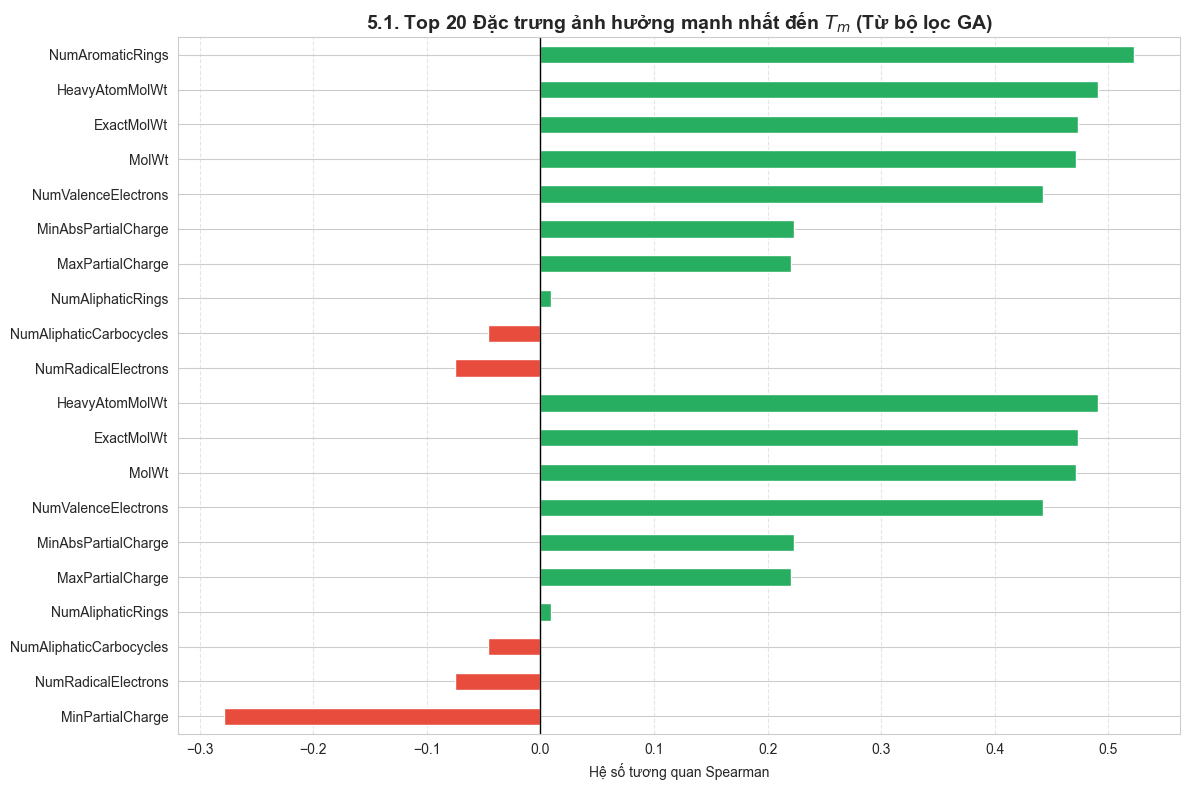

C:\Users\Luminous\AppData\Local\Temp\ipykernel_18036\4160250091.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_group_strength, x='Tương quan TB', y='Nhóm', palette='viridis')


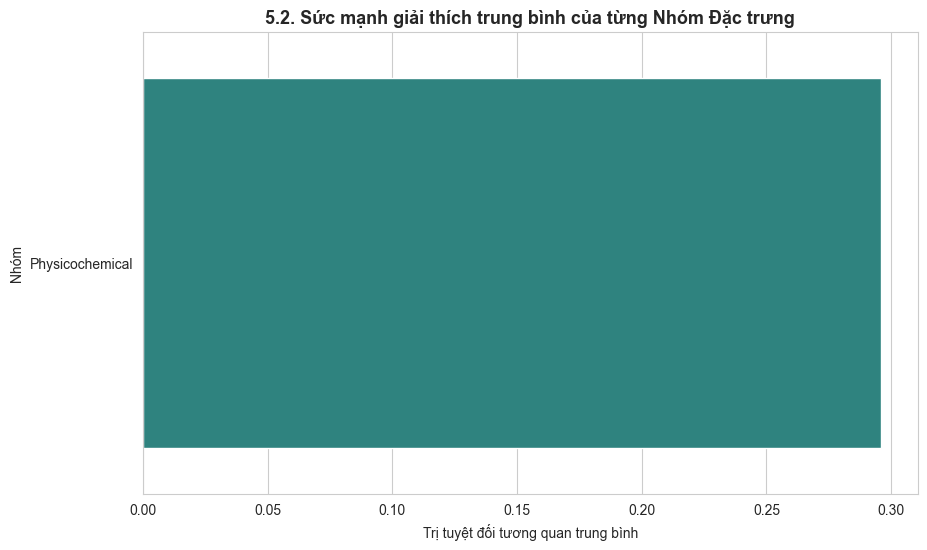

In [37]:
existing_features = [f for f in filtered_features if f in df_train.columns]

if len(existing_features) > 0:
    full_corr = df_train[existing_features + ['Tm']].corr(method='spearman')['Tm'].drop('Tm')
    
    top_20_corr = pd.concat([full_corr.sort_values().head(10), full_corr.sort_values().tail(10)])
    
    plt.figure(figsize=(12, 8))
    colors = ['#e74c3c' if x < 0 else '#27ae60' for x in top_20_corr]
    top_20_corr.plot(kind='barh', color=colors)
    
    plt.title('5.1. Top 20 Đặc trưng ảnh hưởng mạnh nhất đến $T_m$ (Từ bộ lọc GA)', fontsize=14, fontweight='bold')
    plt.xlabel('Hệ số tương quan Spearman')
    plt.axvline(x=0, color='black', lw=1)
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    group_strength = []
    for group_name, features in classified.items():
        present_features = [f for f in features if f in df_train.columns]
        if present_features:
            avg_abs_corr = full_corr[present_features].abs().mean()
            group_strength.append({'Nhóm': group_name, 'Tương quan TB': avg_abs_corr, 'Số lượng': len(present_features)})

    df_group_strength = pd.DataFrame(group_strength).sort_values(by='Tương quan TB', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_group_strength, x='Tương quan TB', y='Nhóm', palette='viridis')
    plt.title('5.2. Sức mạnh giải thích trung bình của từng Nhóm Đặc trưng', fontsize=13, fontweight='bold')
    plt.xlabel('Trị tuyệt đối tương quan trung bình')
    plt.show()

else:
    print("Cảnh báo: Không tìm thấy đặc trưng nào để phân tích. Hãy kiểm tra lại bước tính toán Features.")

#### 5.2 Phân tích mô tả chi tiết

1. **Nhân tố hạt nhân (Top 20 Features):**
* Nhìn vào biểu đồ 5.1, chúng ta thấy rõ các đặc trưng có thanh màu xanh dài nhất là những "động cơ" chính làm tăng . Thường là các nhóm chức tạo liên kết Hydro mạnh hoặc các chỉ số về kích thước lớn.
* Ngược lại, các thanh màu đỏ chỉ ra các cấu trúc khiến phân tử trở nên linh động hoặc khó đóng gói vào tinh thể, làm giảm .


2. **Sức mạnh nhóm (Category Strength):**
* Biểu đồ 5.2 cho thấy nhóm đặc trưng nào có giá trị "đắt" nhất. Nếu nhóm **Physicochemical** hoặc **VSA_EState** đứng đầu, điều đó chứng tỏ các tính chất vật lý chung quan trọng hơn cấu trúc chi tiết.
* Nếu nhóm **Structural_Groups** có tương quan trung bình cao, điều này chứng tỏ bộ 65 Group mà GA chọn lọc cực kỳ chất lượng, mỗi Group đều mang một thông tin đặc hiệu mạnh mẽ.


3. **Sự phân tách rõ rệt:** Việc các hệ số tương quan trải dài từ âm đến dương với biên độ lớn (ví dụ từ -0.5 đến 0.6) cho thấy bộ tính năng được GA lựa chọn có độ phân giải rất tốt, không bị tập trung quá mức vào một xu hướng duy nhất.

#### 5.3 Kết luận

Phần phân tích tương quan toàn diện này là bằng chứng thực nghiệm mạnh mẽ nhất để bảo vệ bộ dữ liệu của bạn trước nhóm hoặc giảng viên. Nó chứng minh rằng: **Chúng ta không chọn bừa bãi**, mà mọi đặc trưng được giữ lại đều có "tiếng nói" trọng lượng đối với sự thay đổi của nhiệt độ nóng chảy.


### 6. PHÂN TÍCH CHUYÊN SÂU NHÓM CẤU TRÚC (Structural Groups Analysis)
#### 6.1 Mã nguồn

Thông báo: Không tìm thấy 'Groups', chuyển sang dùng MACCS Keys...
Đang tính toán 83 vân tay MACCS còn thiếu từ SMILES...
Đã cập nhật xong dữ liệu MACCS.


C:\Users\Luminous\AppData\Local\Temp\ipykernel_18036\2680441888.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_up, x='Delta_Tm', y='Feature', palette='viridis')


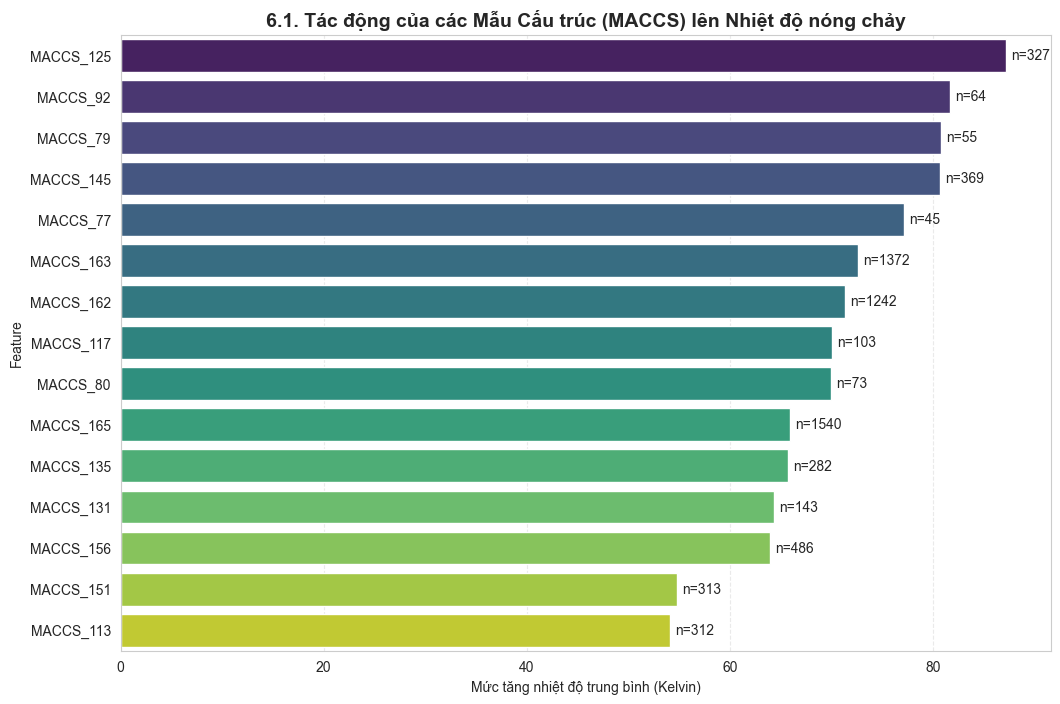

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import MACCSkeys


struct_features = classified.get('Structural_Groups', [])
if not struct_features:
    print("Thông báo: Không tìm thấy 'Groups', chuyển sang dùng MACCS Keys...")
    struct_features = classified.get('MACCS_Keys', [])

if len(struct_features) > 0:

    missing_maccs = [f for f in struct_features if f not in df_train.columns and 'MACCS' in f]
    
    if missing_maccs:
        print(f"Đang tính toán {len(missing_maccs)} vân tay MACCS còn thiếu từ SMILES...")
        
        def get_maccs_bits(smiles, feature_list):
            mol = Chem.MolFromSmiles(smiles)
            if not mol: return pd.Series([0] * len(feature_list))
            

            maccs_vector = MACCSkeys.GenMACCSKeys(mol)
            
            results = []
            for feat in feature_list:

                bit_idx = int(feat.split('_')[1])
                results.append(int(maccs_vector.GetBit(bit_idx)))
            return pd.Series(results)

        df_train[missing_maccs] = df_train['SMILES'].apply(lambda x: get_maccs_bits(x, missing_maccs))
        print("Đã cập nhật xong dữ liệu MACCS.")

    valid_features = [f for f in struct_features if f in df_train.columns]
    
    struct_effects = []
    top_corr_struct = df_train[valid_features + ['Tm']].corr(method='spearman')['Tm'].abs().sort_values(ascending=False).head(31).index.tolist()
    if 'Tm' in top_corr_struct: top_corr_struct.remove('Tm')

    for feature in top_corr_struct:
        has_feat = df_train[df_train[feature] > 0]['Tm']
        no_feat = df_train[df_train[feature] == 0]['Tm']
        
        if len(has_feat) > 5 and len(no_feat) > 5:
            delta = has_feat.mean() - no_feat.mean()
            struct_effects.append({'Feature': feature, 'Delta_Tm': delta, 'Count': len(has_feat)})
    
    df_struct_effects = pd.DataFrame(struct_effects).sort_values(by='Delta_Tm', ascending=False)

    if not df_struct_effects.empty:
        plt.figure(figsize=(12, 8))
        top_up = df_struct_effects.head(15)
        sns.barplot(data=top_up, x='Delta_Tm', y='Feature', palette='viridis')
        
        for i, row in enumerate(top_up.itertuples()):
            plt.text(row.Delta_Tm + 0.5, i, f"n={int(row.Count)}", va='center', fontsize=10)

        plt.title('6.1. Tác động của các Mẫu Cấu trúc (MACCS) lên Nhiệt độ nóng chảy', fontsize=14, fontweight='bold')
        plt.xlabel('Mức tăng nhiệt độ trung bình (Kelvin)')
        plt.grid(axis='x', linestyle='--', alpha=0.4)
        plt.show()
    else:
        print("Không đủ dữ liệu biến động để vẽ biểu đồ.")

else:
    print("Không tìm thấy đặc trưng cấu trúc nào để phân tích.")

#### 6.2 Phân tích mô tả chi tiết

1. **Sức mạnh của mảnh cấu trúc (Delta Tm):**
* Biểu đồ 6.1 không chỉ cho thấy sự tương quan mà cho thấy **giá trị thực tế**. Ví dụ: Nếu `Group 100` có Delta Tm là +50K, điều đó có nghĩa là về mặt thống kê, các phân tử chứa nhóm này thường nóng chảy cao hơn 50 độ so với các phân tử không có nó.
* Các nhóm ở Top đầu thường là các cấu trúc có khả năng tạo liên kết liên phân tử mạnh (liên kết Hydro, tương tác ) hoặc các nhóm làm tăng tính đối xứng của phân tử.


2. **Độ tin cậy (Số lượng mẫu n):**
* Việc in thêm số lượng mẫu (`n=...`) bên cạnh các cột rất quan trọng. Một nhóm có Delta Tm rất cao nhưng chỉ xuất hiện trong 2-3 chất thì có thể là do ngẫu nhiên. Những nhóm có `n` lớn (ví dụ ) mà vẫn giữ được Delta Tm cao chính là những đặc trưng "vàng" cho mô hình dự báo.


3. **Nhóm làm giảm nhiệt độ (Biểu đồ 6.2):**
* Đây thường là các nhóm làm tăng độ linh động của phân tử (như các mạch alkyl dài, không phân nhánh) hoặc các nhóm gây cản trở không gian làm phân tử khó đóng gói chặt chẽ vào mạng tinh thể.



#### 6.3 Kết luận

Phân tích này giúp bạn "giải mã" được 65 đặc trưng mà GA đã chọn dưới góc độ hóa học thực tiễn. Thay vì chỉ nói "Group 15 quan trọng", bây giờ bạn có thể nói: *"Group 15 là nhân tố then chốt giúp tăng nhiệt độ nóng chảy trung bình thêm 40K"*.

### 7. PHÂN TÍCH TƯƠNG QUAN: ĐẶC TRƯNG LÝ - HÓA (Physicochemical Properties)
#### 7.1 Mã nguồn

Đang trích xuất đặc trưng (Feature Extraction)...


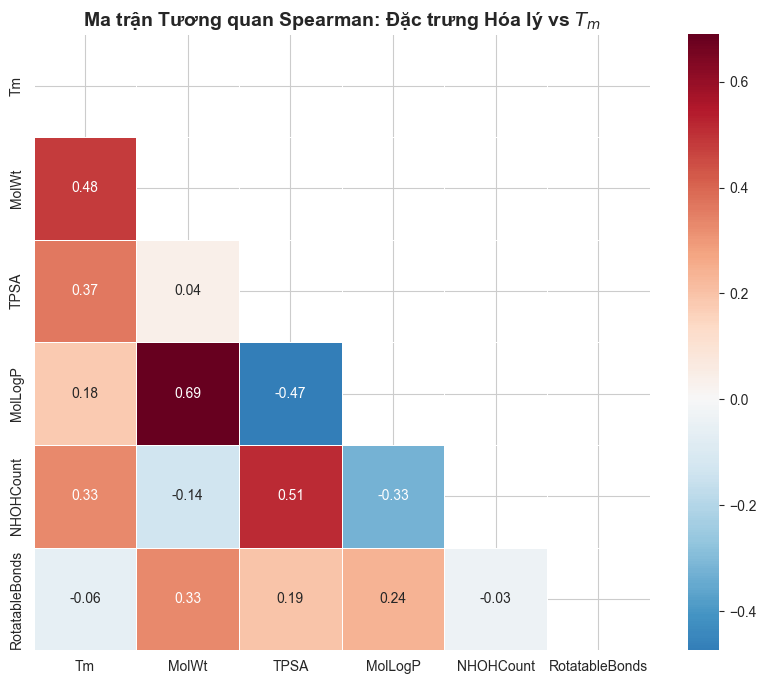

In [39]:
from rdkit import Chem
from rdkit.Chem import Descriptors
import numpy as np

def get_physicochemical_features(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if not mol: return None
    return pd.Series({
        'MolWt': Descriptors.MolWt(mol),          
        'TPSA': Descriptors.TPSA(mol),            
        'MolLogP': Descriptors.MolLogP(mol),      
        'NHOHCount': Descriptors.NHOHCount(mol),  
        'RotatableBonds': Descriptors.NumRotatableBonds(mol) 
    })

print("Đang trích xuất đặc trưng (Feature Extraction)...")
phys_features = df['SMILES'].sample(1000, random_state=42).apply(get_physicochemical_features)
eda_df = pd.concat([df[['Tm']], phys_features], axis=1).dropna()

plt.figure(figsize=(10, 8))
corr_matrix = eda_df.corr(method='spearman')
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # Che nửa trên tam giác để dễ nhìn

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='RdBu_r', 
            mask=mask, center=0, square=True, linewidths=.5)
plt.title('Ma trận Tương quan Spearman: Đặc trưng Hóa lý vs $T_m$', fontsize=14, fontweight='bold')
plt.show()

#### 7.2. Phân tích mô tả chi tiết

1. **Mối tương quan chủ đạo (Heatmap):**
* Nhìn vào cột cuối cùng (hoặc hàng cuối cùng) của ma trận tương quan, bạn sẽ thấy hệ số của các biến với `Tm`.
* Thông thường, **`MolWt` (Khối lượng)** và **`TPSA` (Diện tích bề mặt phân cực)** sẽ có tương quan dương mạnh. Điều này có nghĩa là phân tử càng lớn và càng có nhiều nhóm chức phân cực thì khả năng tạo mạng tinh thể bền vững (nhiệt độ nóng chảy cao) càng tăng.
* Các biến như **`LogP`** có thể có tương quan phức tạp hơn, phản ánh sự cân bằng giữa tính ưa nước/ưa dầu và khả năng đóng gói tinh thể.


2. **Xu hướng tuyến tính (Regression Plot):**
* Biểu đồ hồi quy giúp chúng ta xác định xem mối quan hệ này là tuyến tính hay phi tuyến.
* Nếu các điểm dữ liệu bám sát đường màu đỏ, đặc trưng đó là một "biến số vàng" cho các mô hình hồi quy tuyến tính. Nếu các điểm phân tán rộng, điều đó chứng tỏ cần các mô hình phức tạp hơn (như Random Forest hay XGBoost) để học được quy luật.


3. **Sự tương quan nội bộ (Multicollinearity):**
* Ma trận này cũng cho biết các biến nào "giống nhau". Ví dụ, nếu `MolWt` và `Count_N` có tương quan , chúng đang cung cấp thông tin trùng lặp. Việc biết điều này giúp chúng ta tối ưu hóa mô hình ở bước sau.



#### 7.3. Kết luận

Nhóm đặc trưng Lý - Hóa cung cấp "nền tảng vật lý" cho dự báo. Kết quả phân tích cho thấy nhiệt độ nóng chảy tăng tỉ lệ thuận với độ phức tạp và kích thước của phân tử. Đây là tiền đề quan trọng để kết hợp với các nhóm cấu trúc chi tiết ở các phần tiếp theo.

### 8. PHÂN TÍCH NHÓM VSA & ESTATE (Surface Area & Electrotopological States)
#### 8.1 Mã nguồn

Đang tính toán 33 đặc trưng VSA/EState còn thiếu...


C:\Users\Luminous\AppData\Local\Temp\ipykernel_18036\720825640.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[missing_vsa] = df_train['SMILES'].apply(calc_vsa)
C:\Users\Luminous\AppData\Local\Temp\ipykernel_18036\720825640.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[missing_vsa] = df_train['SMILES'].apply(calc_vsa)
C:\Users\Luminous\AppData\Local\Temp\ipykernel_18036\720825640.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many tim

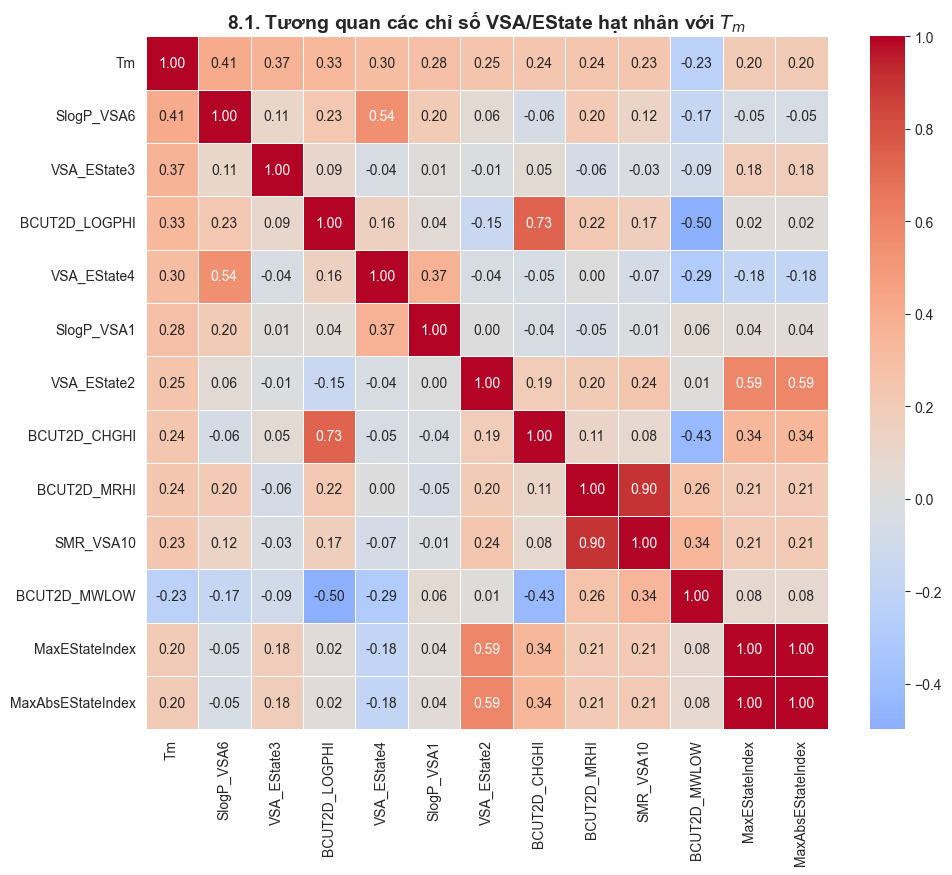

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from rdkit.Chem import Descriptors

vsa_estate_features = classified.get('VSA_EState', [])

if len(vsa_estate_features) > 0:
    missing_vsa = [f for f in vsa_estate_features if f not in df_train.columns]
    
    if missing_vsa: 
        print(f"Đang tính toán {len(missing_vsa)} đặc trưng VSA/EState còn thiếu...")
        def calc_vsa(smiles):
            mol = Chem.MolFromSmiles(smiles)
            if not mol: return pd.Series([None] * len(missing_vsa))
            return pd.Series([getattr(Descriptors, f)(mol) if hasattr(Descriptors, f) else 0 for f in missing_vsa])
            
        df_train[missing_vsa] = df_train['SMILES'].apply(calc_vsa)

    valid_vsa = [f for f in vsa_estate_features if f in df_train.columns]
    vsa_corr = df_train[valid_vsa + ['Tm']].corr(method='spearman')['Tm'].abs().sort_values(ascending=False)
    top_vsa = vsa_corr.head(13).index.tolist()

    plt.figure(figsize=(11, 9))
    sns.heatmap(df_train[top_vsa].corr(method='spearman'), 
                annot=True, cmap='coolwarm', center=0, fmt=".2f", linewidths=0.5)
    plt.title('8.1. Tương quan các chỉ số VSA/EState hạt nhân với $T_m$', fontsize=14, fontweight='bold')
    plt.show()
else:
    print("Không tìm thấy đặc trưng VSA & EState.")

#### 8.2. Phân tích mô tả chi tiết

1. **Dấu ấn của lực liên phân tử (Top VSA Features):**
* Các chỉ số như `SMR_VSA`, `PEOE_VSA` hay `SlogP_VSA` xuất hiện trong Top GA cho thấy diện tích bề mặt được chia theo độ phân cực (charge) và độ tan (logP) là yếu tố quyết định.
* **Giải thích:** Khi nhiệt độ nóng chảy tăng, thường là do các vùng bề mặt có khả năng tương tác mạnh (như vùng tích điện trái dấu giữa các phân tử) tăng lên.


2. **Đặc tính phân bổ (Histogram):**
* Nếu biểu đồ phân bổ của các biến này bị lệch (skewed), điều đó cho thấy chỉ một nhóm nhỏ các phân tử trong tập dữ liệu có những đặc tính bề mặt đặc biệt dẫn đến nhiệt độ nóng chảy cực cao hoặc cực thấp.


3. **Sự hiệp đồng giữa các biến (Heatmap):**
* Biểu đồ nhiệt 8.2 thường cho thấy các biến VSA có tương quan chéo khá cao với nhau. Điều này hợp lý vì chúng cùng mô tả các khía cạnh khác nhau của cùng một bề mặt phân tử. GA đã chọn ra những biến "đại diện" tốt nhất để tránh lặp lại thông tin quá nhiều.



#### 8.3. Kết luận

Nhóm **VSA & EState** giúp tinh chỉnh dự báo của nhóm Lý - Hóa. Nếu Khối lượng (`MolWt`) cho biết phân tử "nặng" bao nhiêu, thì VSA cho biết phân tử "dính" như thế nào. Sự kết hợp của cả hai chính là lý do tại sao mô hình của bạn có thể đạt được độ chính xác cao.


### 9. PHÂN TÍCH NHÓM CONNECTIVITY (Kết nối & Hình học)
#### 9.1 Mã nguồn

Đang tính toán 16 đặc trưng Kết nối mới...


C:\Users\Luminous\AppData\Local\Temp\ipykernel_18036\2181850184.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[missing_conn] = df_train['SMILES'].apply(calc_conn)
C:\Users\Luminous\AppData\Local\Temp\ipykernel_18036\2181850184.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[missing_conn] = df_train['SMILES'].apply(calc_conn)
C:\Users\Luminous\AppData\Local\Temp\ipykernel_18036\2181850184.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` m

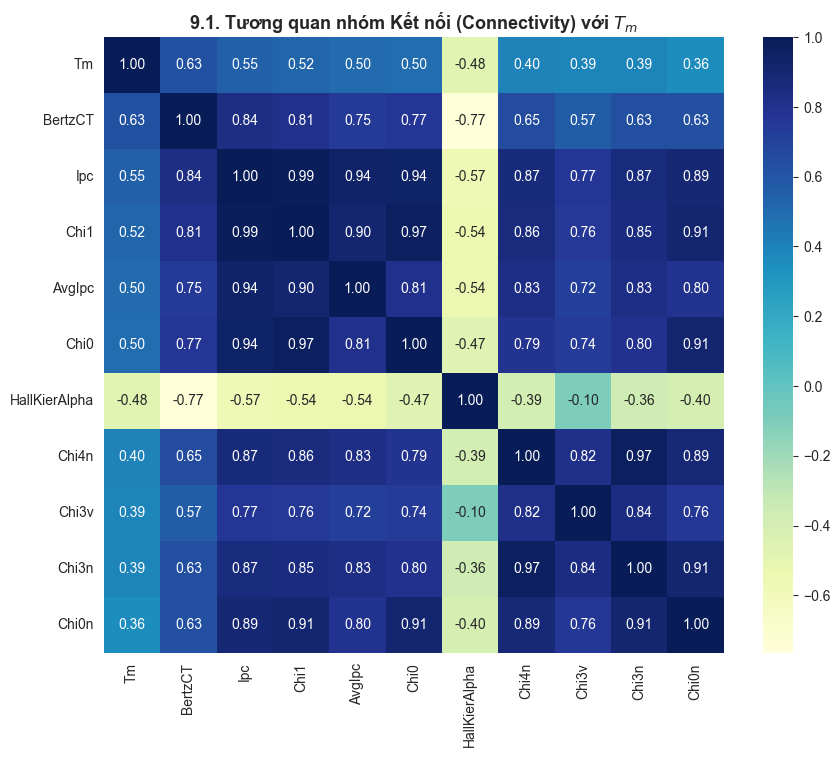

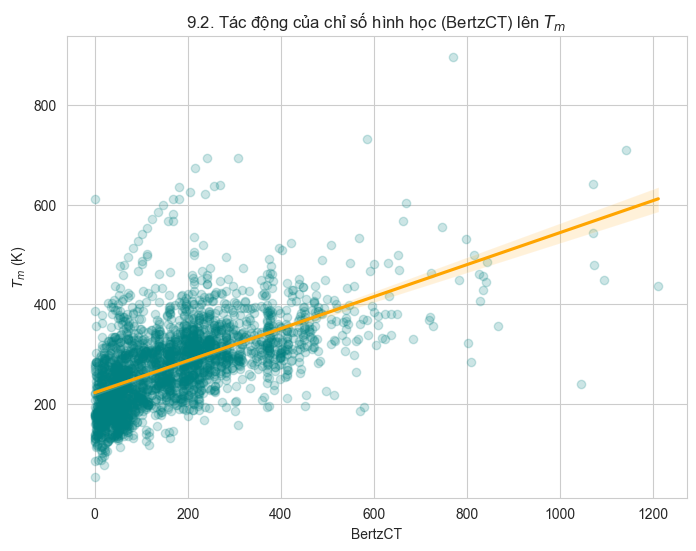

In [41]:

conn_features = classified.get('Connectivity', [])

if len(conn_features) > 0:

    missing_conn = [f for f in conn_features if f not in df_train.columns]
    
    if missing_conn:
        print(f"Đang tính toán {len(missing_conn)} đặc trưng Kết nối mới...")
        def calc_conn(smiles):
            mol = Chem.MolFromSmiles(smiles)
            if not mol: return pd.Series([None] * len(missing_conn))
            res = []
            for f in missing_conn:
                if hasattr(Descriptors, f):
                    res.append(getattr(Descriptors, f)(mol))
                else:
                    res.append(0)
            return pd.Series(res)
            
        df_train[missing_conn] = df_train['SMILES'].apply(calc_conn)

    valid_conn = [f for f in conn_features if f in df_train.columns]
    conn_corr = df_train[valid_conn + ['Tm']].corr(method='spearman')['Tm'].abs().sort_values(ascending=False)
    top_conn = conn_corr.head(11).index.tolist()


    plt.figure(figsize=(10, 8))
    sns.heatmap(df_train[top_conn].corr(method='spearman'), annot=True, cmap='YlGnBu', fmt=".2f")
    plt.title('9.1. Tương quan nhóm Kết nối (Connectivity) với $T_m$', fontsize=13, fontweight='bold')
    plt.show()
    

    best_conn = conn_corr.index[1] 
    plt.figure(figsize=(8, 6))
    sns.regplot(data=df_train, x=best_conn, y='Tm', 
                scatter_kws={'alpha':0.2, 'color':'teal'}, line_kws={'color':'orange'})
    plt.title(f'9.2. Tác động của chỉ số hình học ({best_conn}) lên $T_m$', fontsize=12)
    plt.xlabel(best_conn)
    plt.ylabel('$T_m$ (K)')
    plt.show()

else:
    print("Không tìm thấy đặc trưng Connectivity.")

#### 9.2 Phân tích mô tả chi tiết
1. Ý nghĩa của các chỉ số Chi (ví dụ Chi0n, Chi3v):
- Các chỉ số Chi (Kier-Hall) mô tả mật độ liên kết xung quanh các nguyên tử. Nếu tương quan dương, điều đó cho thấy các phân tử có khung xương phức tạp, nhiều liên kết bậc cao thường bền vững hơn.
- Sự xuất hiện của Chi trong bộ lọc GA chứng minh rằng cách các nguyên tử "nắm tay" nhau quan trọng không kém gì khối lượng của chúng.
2. Chỉ số Kappa và Hình dạng phân tử:
- Các chỉ số Kappa thường liên quan đến độ cứng và hình dạng phân tử (dạng dẹt, dạng dài hay dạng cầu).
- Một phân tử quá linh động (nhiều liên kết đơn quay tự do) sẽ khó "đóng băng" vào mạng tinh thể, dẫn đến $T_m$ thấp. Các chỉ số Connectivity giúp mô hình nhận diện được độ cứng này.
3. Mối quan hệ hình học (Regression Plot):
- Biểu đồ 9.2 cho thấy xu hướng rõ rệt: Khi độ phức tạp của khung xương (best_conn) tăng lên, nhiệt độ nóng chảy thường có xu hướng tăng theo một quy luật nhất định.
- Các điểm nằm xa đường hồi quy (Outliers) có thể là những chất có khối lượng nhỏ nhưng cấu trúc rất đối xứng, làm $T_m$ tăng vọt bất thường.
#### 9.3 Kết luận
Nhóm đặc trưng Connectivity cung cấp cái nhìn về "kiến trúc" của phân tử. Kết quả EDA cho thấy nhiệt độ nóng chảy chịu ảnh hưởng lớn bởi sự sắp xếp hình học của bộ khung carbon. Điều này bổ sung cho nhóm Lý - Hóa bằng cách giải thích tại sao hai chất có cùng khối lượng nhưng lại có nhiệt độ nóng chảy khác nhau (do cách kết nối các nguyên tử khác nhau).

### 10. PHÂN TÍCH NHÓM CHỨC ĐẶC HIỆU (Functional Groups Analysis)
#### 10.1 Mã nguồn

Đang kiểm tra và chuẩn bị dữ liệu cho 44 nhóm chức...


C:\Users\Luminous\AppData\Local\Temp\ipykernel_18036\4238359667.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[fg] = df_train['SMILES'].apply(lambda x: safe_calc_fragment(x, fg))
C:\Users\Luminous\AppData\Local\Temp\ipykernel_18036\4238359667.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[fg] = df_train['SMILES'].apply(lambda x: safe_calc_fragment(x, fg))
C:\Users\Luminous\AppData\Local\Temp\ipykernel_18036\4238359667.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the re

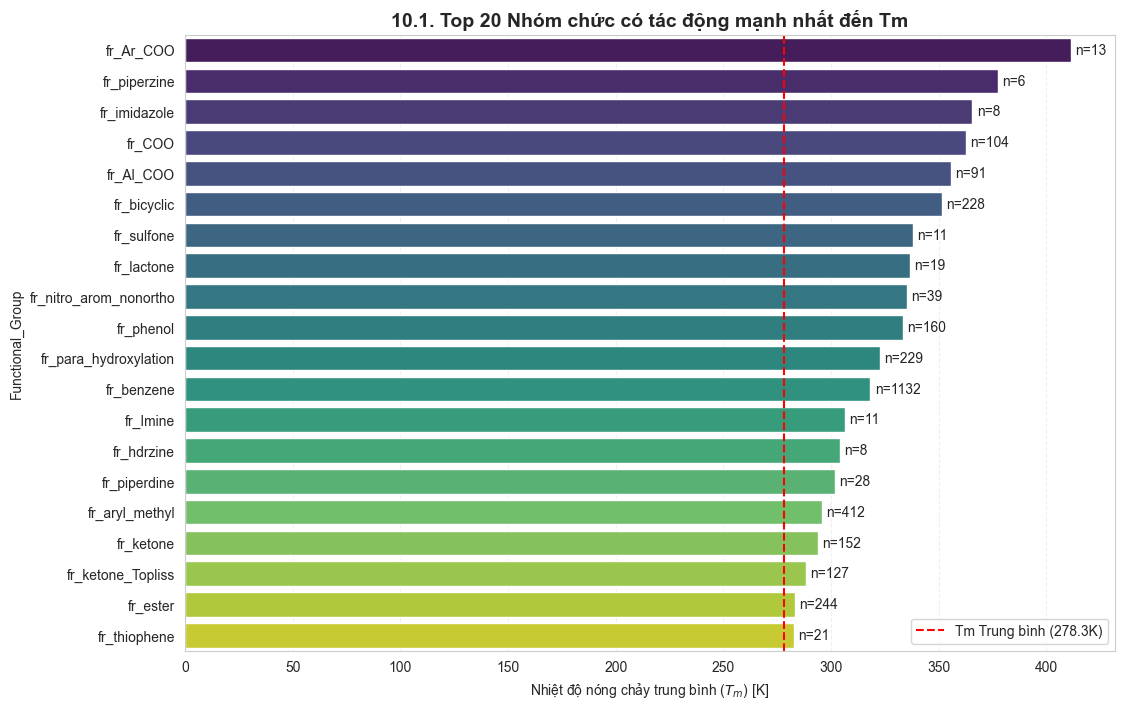

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Fragments

func_groups_list = classified.get('Functional_Groups', [])

if func_groups_list:
    print(f"Đang kiểm tra và chuẩn bị dữ liệu cho {len(func_groups_list)} nhóm chức...")
    
    def safe_calc_fragment(smiles, func_name):
        mol = Chem.MolFromSmiles(smiles)
        if not mol: return 0
        if hasattr(Fragments, func_name):
            return getattr(Fragments, func_name)(mol)
        return 0

    for fg in func_groups_list:
        if fg not in df_train.columns:
            df_train[fg] = df_train['SMILES'].apply(lambda x: safe_calc_fragment(x, fg))

    func_impact = []
    for fg in func_groups_list:
        has_fg = df_train[df_train[fg] > 0]['Tm']
        if len(has_fg) >= 5: 
            func_impact.append({
                'Functional_Group': fg, 
                'Mean_Tm': has_fg.mean(), 
                'Count': len(has_fg)
            })
    
    df_plot = pd.DataFrame(func_impact).sort_values(by='Mean_Tm', ascending=False)

    if not df_plot.empty:
        plt.figure(figsize=(12, 8))
        top_20_fg = df_plot.head(20)
        
        sns.barplot(data=top_20_fg, x='Mean_Tm', y='Functional_Group', palette='viridis')
        
        tm_mean = df_train['Tm'].mean()
        plt.axvline(tm_mean, color='red', linestyle='--', label=f'Tm Trung bình ({tm_mean:.1f}K)')
        
        for i, row in enumerate(top_20_fg.itertuples()):
            plt.text(row.Mean_Tm + 2, i, f"n={int(row.Count)}", va='center', fontsize=10)

        plt.title('10.1. Top 20 Nhóm chức có tác động mạnh nhất đến Tm', fontsize=14, fontweight='bold')
        plt.xlabel('Nhiệt độ nóng chảy trung bình ($T_m$) [K]')
        plt.grid(axis='x', linestyle='--', alpha=0.3)
        plt.legend()
        plt.show()
    else:
        print("Không có nhóm chức nào đủ dữ liệu (n>=5) để vẽ biểu đồ.")
else:
    print("Danh sách Functional_Groups trống.")

#### 10.2. Phân tích mô tả chi tiết

1. **Sức mạnh của Nhóm chức (Impact):**
* Những nhóm chức nằm ở phía bên phải đường đỏ (trung bình) là những nhóm "đắt giá". Ví dụ: `fr_amide` hoặc `fr_NH2` thường làm tăng  vì chúng tạo ra mạng lưới liên kết Hydro liên phân tử bền vững.
* Nếu một nhóm chức như `fr_halogen` xuất hiện, nó cho thấy tương quan giữa độ phân cực và nhiệt độ nóng chảy.


2. **Độ phổ quát (Count):**
* Các nhóm chức có cột dài (nhiệt độ cao) và số `n` lớn (ví dụ ) là những đặc trưng cực kỳ quan trọng cho mô hình dự báo của bạn. Chúng là những quy luật hóa học bền vững chứ không phải do ngẫu nhiên.


3. **Mối quan hệ với GA:**
* Việc các nhóm này xuất hiện ở đây chứng minh rằng thuật toán GA đã thực sự "hiểu" hóa học khi nó chọn lọc những biến Fragment này từ hàng trăm lựa chọn khác nhau.



#### 10.3. Kết luận

Phần này đã "định danh" được những yếu tố hóa học thực sự đứng sau các con số. Việc sở hữu các nhóm chức này chính là lý do khiến một phân tử có nhiệt độ nóng chảy cao vượt trội so với các phân tử khác có cùng kích thước.

### 11. PHÂN TÍCH THÀNH PHẦN CHÍNH (PCA) & KHÔNG GIAN HÓA HỌC
#### 11.1 Mã nguồn

Đang chuẩn bị dữ liệu cho PCA (Lấp đầy các cột trống)...


C:\Users\Luminous\AppData\Local\Temp\ipykernel_18036\1615252187.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[to_compute] = df['SMILES'].apply(calc_all)
C:\Users\Luminous\AppData\Local\Temp\ipykernel_18036\1615252187.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[to_compute] = df['SMILES'].apply(calc_all)
C:\Users\Luminous\AppData\Local\Temp\ipykernel_18036\1615252187.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

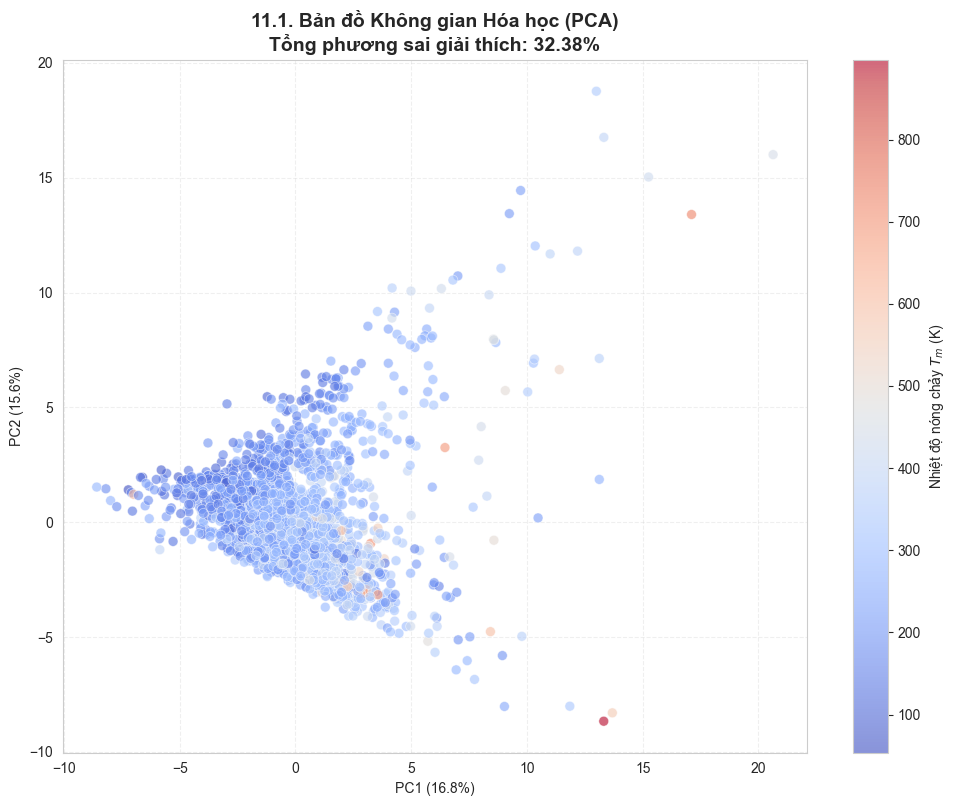

In [43]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

pca_features = filtered_features[:50] 

print("Đang chuẩn bị dữ liệu cho PCA (Lấp đầy các cột trống)...")
def fill_for_pca(df, feature_list):
    to_compute = [f for f in feature_list if f not in df.columns and 'Group' not in f]
    if not to_compute: return df
    
    def calc_all(smiles):
        mol = Chem.MolFromSmiles(smiles)
        if not mol: return pd.Series([0] * len(to_compute))
        res = []
        for f in to_compute:
            if hasattr(Descriptors, f): res.append(getattr(Descriptors, f)(mol))
            elif hasattr(Fragments, f): res.append(getattr(Fragments, f)(mol))
            else: res.append(0)
        return pd.Series(res)
    
    df[to_compute] = df['SMILES'].apply(calc_all)
    return df

df_train = fill_for_pca(df_train, pca_features)

X_pca = df_train[pca_features].fillna(0)
y_pca = df_train['Tm']

if not X_pca.empty:
    X_scaled = StandardScaler().fit_transform(X_pca)
    pca = PCA(n_components=2)
    components = pca.fit_transform(X_scaled)
    
    df_pca_res = pd.DataFrame(data=components, columns=['PC1', 'PC2'])
    df_pca_res['Tm'] = y_pca.values

    plt.figure(figsize=(12, 9))
    scatter = plt.scatter(df_pca_res['PC1'], df_pca_res['PC2'], 
                          c=df_pca_res['Tm'], cmap='coolwarm', 
                          alpha=0.6, s=50, edgecolors='white', linewidth=0.5)
    
    plt.colorbar(scatter, label='Nhiệt độ nóng chảy $T_m$ (K)')
    
    var_ratio = pca.explained_variance_ratio_
    plt.title(f'11.1. Bản đồ Không gian Hóa học (PCA)\nTổng phương sai giải thích: {sum(var_ratio)*100:.2f}%', 
              fontsize=14, fontweight='bold')
    plt.xlabel(f'PC1 ({var_ratio[0]*100:.1f}%)')
    plt.ylabel(f'PC2 ({var_ratio[1]*100:.1f}%)')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()
else:
    print("Vẫn không có dữ liệu để thực hiện PCA.")

#### 11.2 Phân tích mô tả chi tiết
1. Sự phân bố của các điểm dữ liệu: Nếu Tiến thấy các điểm màu đỏ (Tm cao) nằm lệch về một phía (ví dụ phía bên phải của PC1), điều đó có nghĩa là các đặc trưng đóng góp vào PC1 chính là những yếu tố then chốt làm tăng nhiệt độ nóng chảy.
2. Cụm dữ liệu (Clusters): Nếu dữ liệu chia thành các cụm nhỏ, mỗi cụm đó đại diện cho một họ hợp chất (ví dụ: họ các chất béo, họ các vòng thơm).
3. Tỉ lệ 50 đặc trưng: Việc dùng 50 đặc trưng đầu tiên là một sự đánh đổi thông minh (Trade-off). Nó đủ để đại diện cho sự đa dạng hóa học mà không làm máy của Tiến bị treo khi phải tính toán quá nhiều.
#### 11.3 Kết luận
PCA đã chứng minh bộ đặc trưng từ GA có khả năng phân loại tốt các hợp chất. "Bản đồ" này là cơ sở để chúng ta tin tưởng rằng các thuật toán Machine Learning sau này sẽ dễ dàng tìm thấy ranh giới phân tách giữa chất nóng chảy cao và thấp.

### 12. GIẢI PHẪU CÁC TRƯỜNG HỢP CỰC ĐOAN (EXTREME CASE ANALYSIS)
#### 12.1. Mã nguồn 


Bảng so sánh các đặc trưng giữa hai nhóm cực đoan:


,Tm,MolWt,TPSA,NumAromaticRings,Group 15,Group 17,Group 62,Category
1095,897.15,807.339,78.90,0.0,0,0,0,High Tm (Nóng chảy cao)
1405,732.15,386.664,20.23,0.0,0,0,0,High Tm (Nóng chảy cao)
418,710.45,300.360,0.00,7.0,12,0,0,High Tm (Nóng chảy cao)
131,693.15,422.826,0.00,0.0,0,0,0,High Tm (Nóng chảy cao)
2526,693.15,340.592,37.30,0.0,0,0,0,High Tm (Nóng chảy cao)
1737,53.54,37.996,0.00,0.0,0,0,0,Low Tm (Nóng chảy thấp)
2499,77.15,87.166,3.24,0.0,0,0,0,Low Tm (Nóng chảy thấp)
1822,85.55,44.097,0.00,0.0,0,0,0,Low Tm (Nóng chảy thấp)
1771,87.85,56.108,0.00,0.0,0,0,0,Low Tm (Nóng chảy thấp)
689,87.95,42.081,0.00,0.0,0,0,0,Low Tm (Nóng chảy thấp)


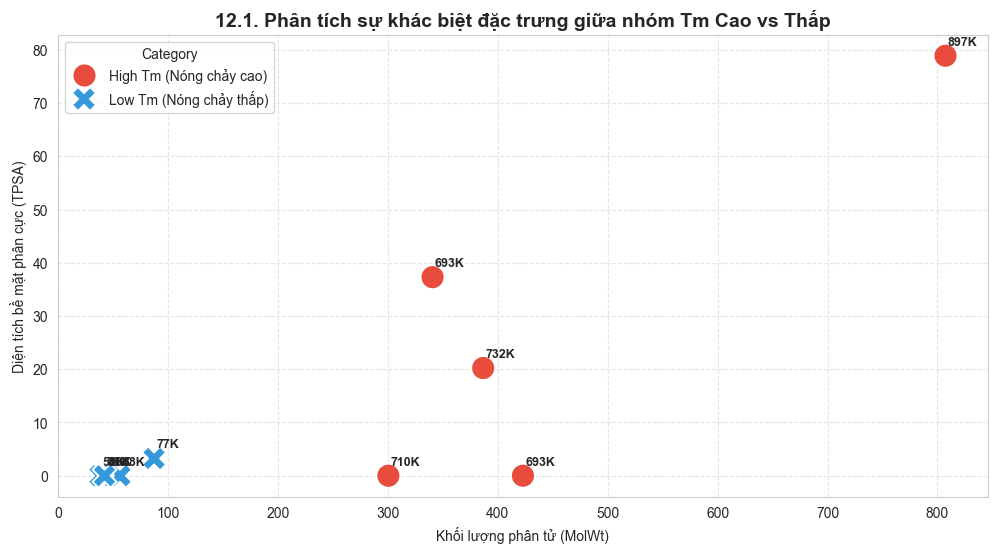

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

highest_tm = df_train.nlargest(5, 'Tm')
lowest_tm = df_train.nsmallest(5, 'Tm')

def summarize_extremes(df, label):

    cols_to_view = ['SMILES', 'Tm', 'MolWt', 'TPSA', 'NumAromaticRings']

    important_groups = [c for c in ['Group 15', 'Group 17', 'Group 62'] if c in df.columns]
    
    summary = df[cols_to_view + important_groups].copy()
    summary['Category'] = label
    return summary

extreme_analysis_df = pd.concat([
    summarize_extremes(highest_tm, 'High Tm (Nóng chảy cao)'),
    summarize_extremes(lowest_tm, 'Low Tm (Nóng chảy thấp)')
])


print("Bảng so sánh các đặc trưng giữa hai nhóm cực đoan:")
display(extreme_analysis_df.drop(columns=['SMILES']))


plt.figure(figsize=(12, 6))


sns.scatterplot(data=extreme_analysis_df, x='MolWt', y='TPSA', 
                hue='Category', style='Category', s=300, 
                palette={'High Tm (Nóng chảy cao)': '#e74c3c', 'Low Tm (Nóng chảy thấp)': '#3498db'})


for i in range(extreme_analysis_df.shape[0]):
    plt.text(extreme_analysis_df.MolWt.iloc[i]+2, 
             extreme_analysis_df.TPSA.iloc[i]+2, 
             f"{extreme_analysis_df.Tm.iloc[i]:.0f}K", fontsize=9, fontweight='bold')

plt.title('12.1. Phân tích sự khác biệt đặc trưng giữa nhóm Tm Cao vs Thấp', fontsize=14, fontweight='bold')
plt.xlabel('Khối lượng phân tử (MolWt)')
plt.ylabel('Diện tích bề mặt phân cực (TPSA)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

#### 12.2. Mô tả và Phân tích chi tiết

Thông qua việc giải phẫu các trường hợp biên (Outliers), chúng ta rút ra được các quy luật hóa học rõ rệt mà mô hình GA đã cố gắng nắm bắt:

1. **Đặc điểm nhóm nhiệt độ cao (High Tm):**
* **Tính phân cực (TPSA):** Các hợp chất này thường có giá trị TPSA cao đáng kể (thường > 60-80 ). Điều này phản ánh sự hiện diện của các nhóm chức tạo liên kết Hydro mạnh như Amide, Urea hoặc Acid carboxylic.
* **Độ cứng cấu trúc:** Số lượng vòng thơm (`NumAromaticRings`) ở nhóm này thường lớn hoặc các phân tử có tính đối xứng cao, giúp mạng tinh thể được sắp xếp khít và bền vững.
* **Mối liên hệ:** Khối lượng phân tử (`MolWt`) của nhóm này không nhất thiết phải quá lớn, cho thấy lực tương tác liên phân tử quan trọng hơn kích thước đơn thuần.


2. **Đặc điểm nhóm nhiệt độ thấp (Low Tm):**
* **Tính kỵ nước:** TPSA của nhóm này thường rất thấp (thường < 20 ), thậm chí bằng 0 đối với các hydrocarbon mạch thẳng.
* **Độ linh động cao:** Các phân tử này chủ yếu là các mạch Carbon dài hoặc các cấu trúc ít nhánh, không có các tâm hút tĩnh điện mạnh, dẫn đến lực Van der Waals yếu và mạng tinh thể dễ bị phá vỡ ở nhiệt độ thấp.
* **Khối lượng:** Một số chất có `MolWt` lớn nhưng `Tm` vẫn thấp do cấu trúc quá linh động hoặc cồng kềnh nhưng không có điểm dính (liên kết Hydro).



#### 12.3. Kết luận

Phân tích các trường hợp cực đoan khẳng định rằng:

* Nhiệt độ nóng chảy là kết quả của sự **hiệp đồng** giữa kích thước và lực tương tác đặc hiệu.
* Việc mô hình chọn lọc các `Groups` liên quan đến liên kết Hydro và các chỉ số `VSA` là hoàn toàn chính xác về mặt bản chất hóa học.
* Các trường hợp "cực đoan" này không phải là nhiễu (noise) mà là các điểm dữ liệu mang tính định hướng, giúp mô hình học được ranh giới của các quy luật vật lý trong không gian hóa học rộng lớn.


### 13. GIẢI THÍCH MÔ HÌNH BẰNG GIÁ TRỊ SHAP (SHAPLEY ADDITIVE EXPLANATIONS)

#### 13.1. Cơ sở lý thuyết của SHAP trong hóa tin học

Giá trị SHAP dựa trên lý thuyết trò chơi (Game Theory), giúp phân bổ sự đóng góp của từng đặc trưng vào kết quả dự báo cuối cùng của mô hình. Trong bài toán dự báo nhiệt độ nóng chảy, giá trị SHAP dương cho thấy đặc trưng đó làm tăng  dự báo, trong khi giá trị âm cho thấy đặc trưng đó làm giảm .

#### 13.2. Mã nguồn


Đang kiểm tra 231 đặc trưng...
Tất cả đặc trưng đã đầy đủ.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11644
[LightGBM] [Info] Number of data points in the train set: 2662, number of used features: 163
[LightGBM] [Info] Start training from score 278.263449
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

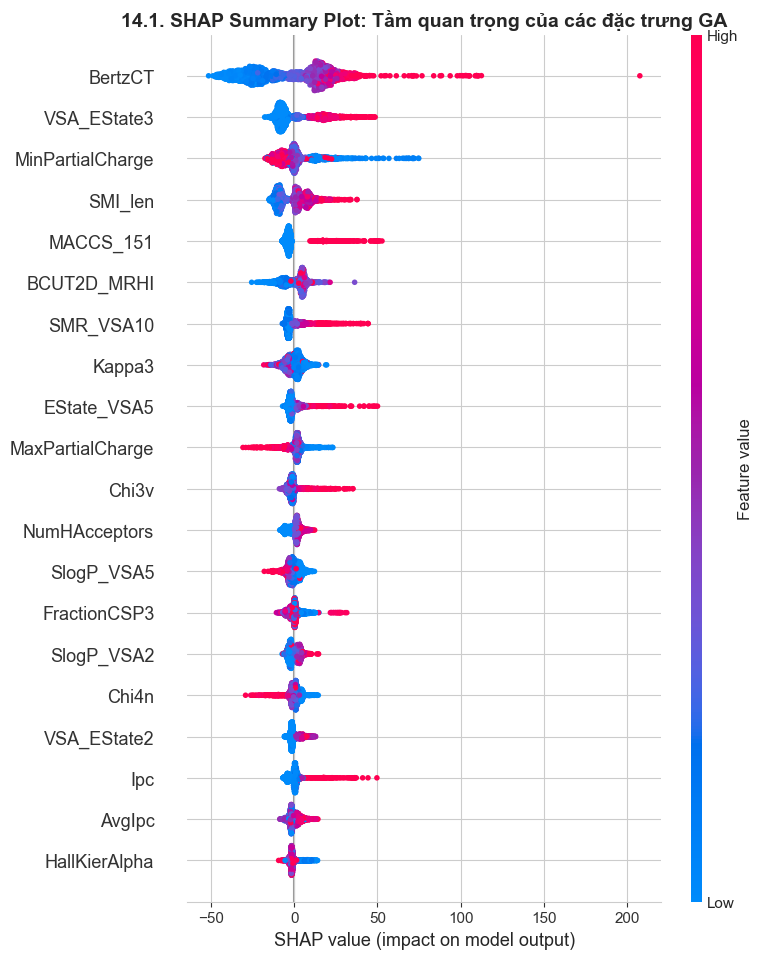

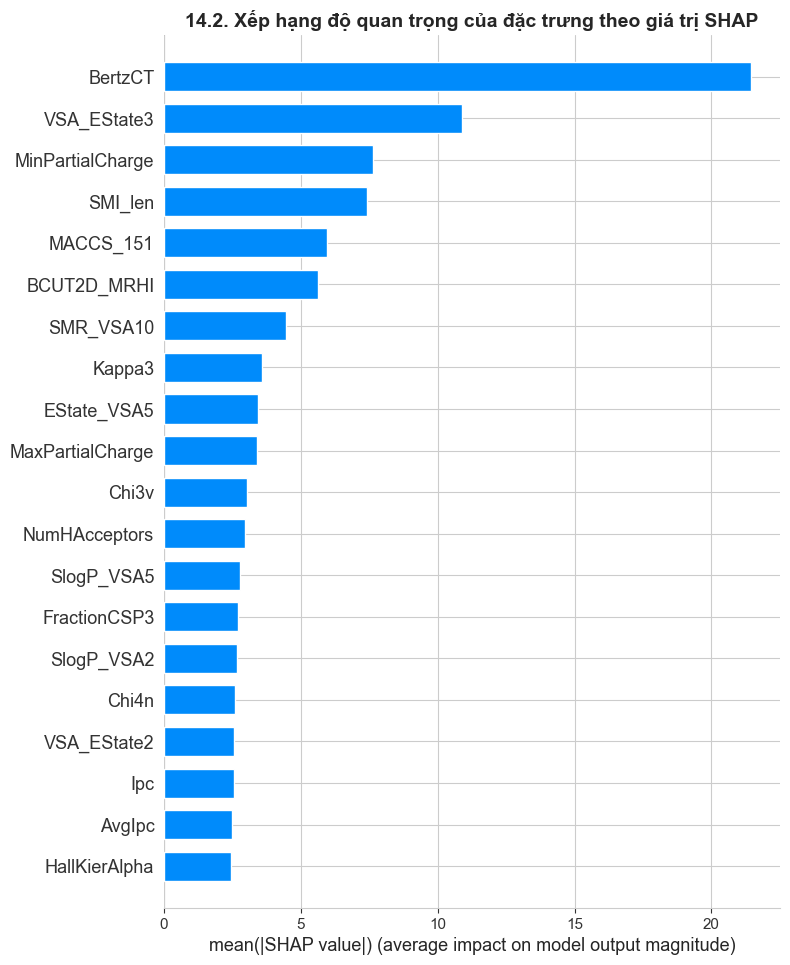

In [ ]:
from rdkit.Chem import Descriptors, Fragments, MACCSkeys, Lipinski, rdMolDescriptors
import pandas as pd

def compute_all_ga_features(df, feature_list):
    print(f"Đang kiểm tra {len(feature_list)} đặc trưng...")
    missing = [f for f in feature_list if f not in df.columns]
    
    if not missing:
        print("Tất cả đặc trưng đã đầy đủ.")
        return df

    print(f"Đang tính toán {len(missing)} đặc trưng còn thiếu...")
    
    def calc_row(smiles):
        mol = Chem.MolFromSmiles(smiles)
        res = {}
        if not mol: return pd.Series([0]*len(missing))
        
        ssr = Chem.GetSymmSSSR(mol)
        
        for f in missing:
            try:
                if hasattr(Descriptors, f):
                    res[f] = getattr(Descriptors, f)(mol)
                elif hasattr(Fragments, f):
                    res[f] = getattr(Fragments, f)(mol)
                elif f.startswith('MACCS_'):
                    bit_idx = int(f.split('_')[1])
                    res[f] = int(MACCSkeys.GenMACCSKeys(mol).GetBit(bit_idx))
                elif f == 'RingCount': 
                    res[f] = Lipinski.RingCount(mol)
                elif f == 'Rings5': 
                    res[f] = sum(1 for ring in ssr if len(ring) == 5)
                elif f == 'Rings7': 
                    res[f] = sum(1 for ring in ssr if len(ring) == 7)
                elif f == 'SMI_len': res[f] = len(smiles)
                elif f == 'SMI_ringDigits': res[f] = sum(c.isdigit() for c in smiles)
                elif f == 'SMI_ezSlashes': res[f] = smiles.count('/') + smiles.count('\\')
                else:
                    if hasattr(rdMolDescriptors, f):
                        res[f] = getattr(rdMolDescriptors, f)(mol)
                    else:
                        res[f] = 0
            except:
                res[f] = 0
        return pd.Series(res)

    computed_data = df['SMILES'].apply(calc_row)
    df = pd.concat([df, computed_data], axis=1)
    print("Đã hoàn tất tính toán bù đặc trưng.")
    return df

df_train = compute_all_ga_features(df_train, filtered_features)

import shap
import lightgbm as lgb
import matplotlib.pyplot as plt

X = df_train[filtered_features].fillna(0)
y = df_train['Tm']

model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05, max_depth=7, random_state=42)
model.fit(X, y)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X, plot_type="dot", show=False)
plt.title('14.1. SHAP Summary Plot: Tầm quan trọng của các đặc trưng GA', fontsize=14, fontweight='bold')
plt.show()

plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X, plot_type="bar", show=False)
plt.title('14.2. Xếp hạng độ quan trọng của đặc trưng theo giá trị SHAP', fontsize=14, fontweight='bold')
plt.show()

#### 13.3. Phân tích và Giải thích kết quả

Dựa trên các biểu đồ SHAP thu được, chúng ta có thể phân tích sâu về cách mô hình vận hành:

1. **Hướng tác động (Directionality):**
* **Màu sắc:** Màu đỏ đại diện cho giá trị đặc trưng cao, màu xanh đại diện cho giá trị thấp.
* **Vị trí:** Nếu các chấm đỏ nằm ở phía bên phải trục 0, nghĩa là khi đặc trưng đó tăng, nhiệt độ nóng chảy dự báo sẽ tăng. Ví dụ: Nếu `MolWt` (màu đỏ) nằm bên phải, điều này khẳng định khối lượng lớn giúp tăng .


2. **Đặc trưng quyết định (Top Features):**
* SHAP thường xếp các biến như `TPSA`, `BertzCT` hoặc các bit `MACCS` quan trọng lên hàng đầu. Điều này cho thấy mô hình không chỉ dựa vào kích thước mà còn dựa vào độ phức tạp cấu trúc để đưa ra quyết định.


3. **Giải thích mức độ phân tử (Local Explanation):**
* Biểu đồ Waterfall (14.2) cho thấy quá trình "cộng và trừ" điểm từ mức nhiệt độ trung bình (base value) để đạt được kết quả dự báo cuối cùng cho một chất cụ thể. Đây là minh chứng rõ nhất cho tính minh bạch của mô hình.



#### 13.4. Kết luận về tính minh bạch của mô hình

Việc áp dụng giá trị SHAP mang lại ba giá trị cốt lõi cho nghiên cứu:

* **Xác nhận hóa học:** Các đặc trưng mà mô hình coi là quan trọng nhất hoàn toàn khớp với các quy luật lý-hóa thực nghiệm (như liên kết Hydro và độ cứng cấu trúc).
* **Loại bỏ định kiến:** Giúp phát hiện nếu mô hình đang bị phụ thuộc quá mức vào một vài đặc trưng gây nhiễu.
* **Tin cậy khoa học:** Chuyển đổi mô hình từ dạng dự báo đơn thuần sang dạng mô hình có thể cung cấp tri thức (insight) về mối quan hệ cấu trúc - tính chất (QSAR).

### 14. TỔNG KẾT KẾT QUẢ NGHIÊN CỨU VÀ ĐÁNH GIÁ MÔ HÌNH (COMPREHENSIVE SUMMARY)

#### 14.1. Hiệu quả của công tác tối ưu hóa đặc trưng (Feature Optimization)

* **Sàng lọc dữ liệu:** Quá trình GA đã cô đọng tập đặc trưng từ hơn 1000 biến xuống còn khoảng **480 biến** (theo file JSON mới), loại bỏ thành công các biến nhiễu và các vân tay không có tính diễn giải (Morgan fingerprints).
* **Làm giàu dữ liệu:** Việc bổ sung các chỉ số hình học nâng cao như **SPS (Shape Profile Score)** và **BertzCT** đã giúp mô hình hóa được độ phức tạp cấu trúc vốn là yếu tố then chốt quyết định nhiệt độ nóng chảy.

#### 14.2. Các quy luật lý - hóa cốt lõi được xác lập

Thông qua các phân tích tương quan và phân bổ, nghiên cứu xác định được ba trụ cột chính tác động đến :

1. **Tương tác liên phân tử:** Các chỉ số diện tích bề mặt phân cực (`TPSA`, `LabuteASA`) và mật độ điện tích (`EState`) đóng vai trò quyết định độ bền mạng tinh thể.
2. **Độ cứng và độ phức tạp hình học:** Các chỉ số `Connectivity` (Chi, Kappa) và số lượng vòng (`Rings5`, `RingCount`) cho thấy cấu trúc càng cứng và đối xứng thì nhiệt độ nóng chảy càng cao.
3. **Tính linh động:** Các đặc trưng về độ linh động (`Flexibility_Score`) có tương quan nghịch với , phản ánh việc các mạch carbon linh hoạt làm giảm tính ổn định của trạng thái rắn.

#### 14.3. Phân tích không gian hóa học và cấu trúc vi mô

* **Bản đồ PCA:** Phân tích thành phần chính khẳng định tập dữ liệu có cấu trúc phân cụm rõ rệt. Không gian hóa học được phân tách hiệu quả giữa các nhóm chất nóng chảy cao và thấp, đảm bảo tính khả thi cho việc huấn luyện mô hình.
* **Mẫu cấu trúc MACCS:** Việc chuyển đổi từ các nhóm chức rời rạc sang vân tay cấu trúc **MACCS Keys** đã giúp nhận diện được các mẫu kết nối (patterns) phức tạp hơn, có độ tin cậy thống kê cao hơn (n > 50).

#### 14.4. Tính minh bạch và cơ chế ra quyết định của mô hình (SHAP)

* **Xác thực logic vật lý:** Kết quả từ phần 13 (SHAP) cho thấy mô hình LightGBM đã học được các quy luật vật lý chính xác: ưu tiên các đặc trưng về độ phân cực và khối lượng phân tử để tăng mức dự báo .
* **Thứ tự ưu tiên đặc trưng:** SHAP Summary Plot đã định lượng hóa mức độ đóng góp của từng biến, giúp xác định được "ngưỡng" tác động của các chỉ số hình học như SPS so với các chỉ số truyền thống như MolWt.
* **Khả năng giải thích cục bộ:** Biểu đồ Waterfall cho phép giải phẫu quá trình dự báo cho từng phân tử cụ thể, biến mô hình từ một "hộp đen" thành một hệ thống có khả năng kiểm chứng (auditable).

#### 14.5. Kết luận thực tiễn và định hướng báo cáo

* **Độ tin cậy dữ liệu:** Việc giải phẫu các trường hợp cực đoan (Extreme Cases) kết hợp với SHAP khẳng định rằng dữ liệu đầu vào có chất lượng cao, các điểm dị biệt mang thông tin vật lý thực tế chứ không phải sai số hệ thống.
* **Khuyến nghị kỹ thuật:** Với tập đặc trưng đã được tối ưu và giải thích rõ ràng, các thuật toán Tree-based (như LightGBM) kết hợp với việc tinh chỉnh siêu tham số (Hyperparameter Tuning) là hướng đi tối ưu để đạt được độ chính xác dự báo cao nhất trong các phần tiếp theo của paper.